# Explore Risk Factors for COVID-19 for Counties in US States
[Work in progress]

This notebook explores the relationsship between risk factors selected from the American Community Survey 2018 5-year estimates on COVID-19 confirmed case and death rate.

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Query KG to get Confirmed Cases, Deaths, and Population for Counties in a State

In [4]:
state = 'California'
#state = 'Arizona'
#state = 'Florida'

In [5]:
start_date = '2020-04-01'

In [6]:
metric = 'confirmedRate'
#metric = 'deathRate'

In [7]:
query = """
// get all counties (admin2) in a state (admin1)
MATCH (a:Admin2)-[:IN]->(:Admin1{name: $admin1})

// get COVID-19 cases for all counties
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'}) 
WHERE c.date >= date($start_date)

// get demographics for all counties
MATCH (a)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

RETURN a.name AS name, c.date AS date, 
       c.cummulativeConfirmed*100000.0/d.totalPopulation AS confirmedRate, 
       c.cummulativeDeaths*100000.0/d.totalPopulation AS deathRate
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, admin1=state, start_date=start_date).to_data_frame()

Reformat data

In [8]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,Alameda County,Alpine County,Amador County,Butte County,Calaveras County,City and County of San Francisco,Colusa County,Contra Costa County,Del Norte County,El Dorado County,Fresno County,Glenn County,Humboldt County,Imperial County,Inyo County,Kern County,Kings County,Lake County,Lassen County,Los Angeles County,Madera County,Marin County,Mariposa County,Mendocino County,Merced County,Modoc County,Mono County,Monterey County,Napa County,Nevada County,Orange County,Placer County,Plumas County,Riverside County,Sacramento County,San Benito County,San Bernardino County,San Diego County,San Joaquin County,San Luis Obispo County,San Mateo County,Santa Barbara County,Santa Clara County,Santa Cruz County,Shasta County,Sierra County,Siskiyou County,Solano County,Sonoma County,Stanislaus County,Sutter County,Tehama County,Trinity County,Tulare County,Tuolumne County,Ventura County,Yolo County,Yuba County
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,19.042404,87.260035,5.286949,3.523065,6.632033,49.882535,4.658964,21.972262,0.000000,9.643150,6.952041,7.16923,19.886866,21.085808,49.764999,12.456783,2.665334,0.0,0.0,34.838402,14.837465,41.107205,0.0,4.575507,3.716436,0.0,91.717229,9.695022,10.673877,26.238243,19.151869,20.522157,5.347880,15.566743,14.834211,35.344015,8.569771,22.193069,20.622443,28.423727,50.657040,22.310462,49.734679,17.898563,3.908758,0.0,6.890216,11.173694,15.559018,7.231583,10.430574,0.000000,0.0,9.772475,3.708374,18.865433,11.629151,9.272383
2020-04-02,21.840969,87.260035,7.930424,3.963448,6.632033,51.721522,4.658964,22.060504,0.000000,9.643150,8.383344,7.16923,20.623416,23.860257,49.764999,16.080575,3.331667,0.0,0.0,40.057231,16.127680,41.491385,0.0,4.575507,4.459723,0.0,126.993086,11.080025,12.808653,26.238243,20.732056,23.679412,5.347880,20.685726,20.794385,38.710112,11.894655,25.705205,23.627037,31.621396,59.143400,25.014761,53.012174,19.724947,3.908758,0.0,6.890216,12.313867,18.152187,8.158709,14.602804,0.000000,0.0,16.070292,3.708374,20.869885,13.024649,10.597009
2020-04-03,26.951390,87.260035,7.930424,4.403831,6.632033,57.123548,4.658964,27.090299,3.646441,10.178880,9.610175,7.16923,27.252372,28.854264,55.294443,19.591123,3.331667,0.0,0.0,45.216642,18.063001,45.333180,0.0,4.575507,5.946298,0.0,126.993086,12.234195,12.808653,30.274896,22.470262,25.521144,5.347880,20.685726,25.827421,38.710112,14.236122,29.247619,24.583044,33.042582,63.451859,31.324791,53.012174,20.820777,6.142335,0.0,6.890216,13.910109,18.950085,9.456686,14.602804,0.000000,0.0,17.590455,3.708374,22.284793,15.350479,10.597009
2020-04-04,26.951390,87.260035,7.930424,4.844214,8.842710,60.801523,9.317928,27.090299,7.292882,11.786072,10.223590,7.16923,32.408226,30.518933,55.294443,23.781132,3.331667,0.0,0.0,45.602855,18.063001,50.327513,0.0,4.575507,5.946298,0.0,134.048257,13.157530,14.231837,31.284059,24.840543,25.521144,10.695759,26.769762,25.827421,38.710112,16.530760,33.668066,25.265907,33.042582,70.240947,34.254447,59.723234,21.551331,6.700729,0.0,6.890216,16.646524,20.944831,10.754662,16.688919,1.577959,0.0,17.590455,3.708374,23.935518,17.211144,11.921635
2020-04-05,34.434508,87.260035,0.000000,4.844214,8.842710,65.284055,9.317928,34.061418,7.292882,11.786072,10.530298,7.16923,32.408226,31.628712,60.823887,26.046002,3.331667,0.0,0.0,58.971770,18.063001,52.632590,0.0,4.575507,10.034377,0.0,134.048257,14.311700,14.231837,31.284059,26.357523,27.099772,16.043639,33.525141,29.271077,38.710112,17.420518,36.604939,26.085341,33.753175,72.460457,37.860179,62.792633,25.204098,9.492699,0.0,6.890216,16.646524,21.343780,12.052639,16.688919,1.577959,0.0,25.191269,3.708374,26.057879,17.211144,11.921635


### Get Risk Factors for Counties

* Low income (< $15,000)
* No health insurance
* Service occupation
* Low education level (no high school diploma)
* High occupancy housing (> 1 occupant per room)

In [9]:
query = """
// get counties in state
MATCH (a:Admin2)-[:IN]-(:Admin1{name: $admin1})

// get population characteristics (American Community Survey 2018 5-year estimates)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_INCOME]-(i:Income)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_HEALTH_INSURANCE]-(hi:HealthInsurance)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_OCCUPATION]-(o:Occupation)
MATCH (a)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
MATCH (a)-[:HAS_HOUSING]-(h:Housing)

// return risk factors
RETURN a.name AS name, 
       (i.householdIncomeLessThan10000USDPct + i.householdIncome10000To14999USDPct) AS lowIncomePct,
       hi.noHealthInsuranceCoveragePct AS noHealthInsurancePct,
       o.serviceOccupationsPct AS serviceOccupationPct,
       e.lessThan9thGradePct + e.grade9thTo12thNoDiplomaPct AS lowEducationPct,
       (h.`occupantsPerRoom1.01to1.50Pct` + h.`occupantsPerRoom1.51orMorePct`) AS highOccupanyHousingPct
ORDER BY a.name
"""
risk_factors = graph.run(query, admin1=state).to_data_frame()
risk_factors.head()

,name,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,highOccupanyHousingPct
0,Alameda County,8.0,5.1,15.8,12.0,7.7
1,Alpine County,10.4,10.3,21.6,11.1,2.3
2,Amador County,8.1,4.2,23.0,9.7,2.8
3,Butte County,15.0,7.4,21.7,10.7,3.2
4,Calaveras County,8.8,5.2,19.6,9.6,2.0


##### Create color maps for risk factors

In [10]:
def get_color_map(factor):
    max_pct = math.ceil(risk_factors[factor].max()*10) + 1
    colors = cm.bwr(np.linspace(0, 1, max_pct))
    risk_factors[factor+'col'] = risk_factors[factor].apply(lambda p: colors[int(round(p*10))])
    return risk_factors[factor+'col'].values

In [11]:
col_income = get_color_map('lowIncomePct')
col_insurance = get_color_map('noHealthInsurancePct')
col_service = get_color_map('serviceOccupationPct')
col_education = get_color_map('lowEducationPct')
col_occupancy = get_color_map('highOccupanyHousingPct')

### Case rate for all counties color-coded by risk factor

##### Set color map for risk factor

In [16]:
#col_map = col_income
#col_map = col_insurance
#col_map = col_service
col_map = col_education
#col_map = col_occupancy

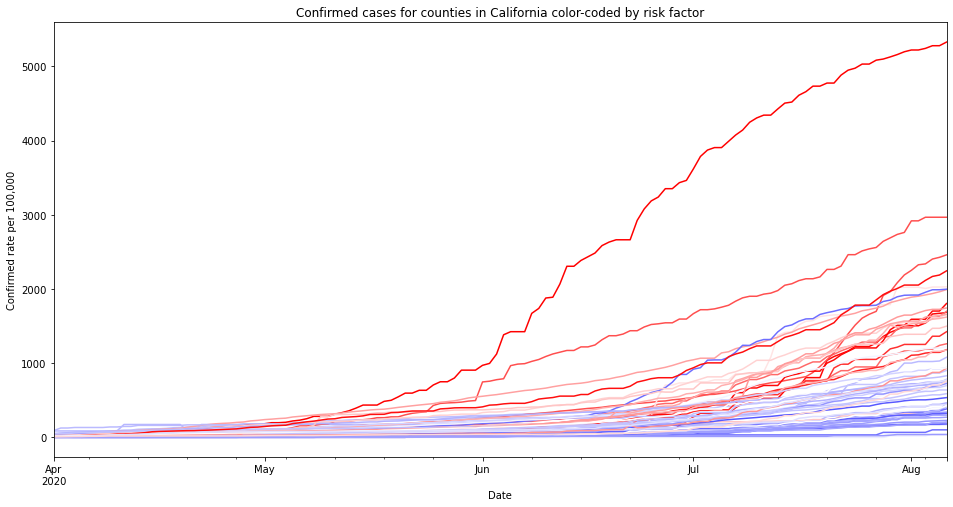

In [17]:
ax = df_date.plot(figsize=(16, 8), color=col_map, legend=False, title=f'Confirmed cases for counties in {state} color-coded by risk factor');
ax.set_xlabel("Date");
ax.set_ylabel("Confirmed rate per 100,000");

### Case counts by county color-coded by risk factor

In [18]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[0]/cols)

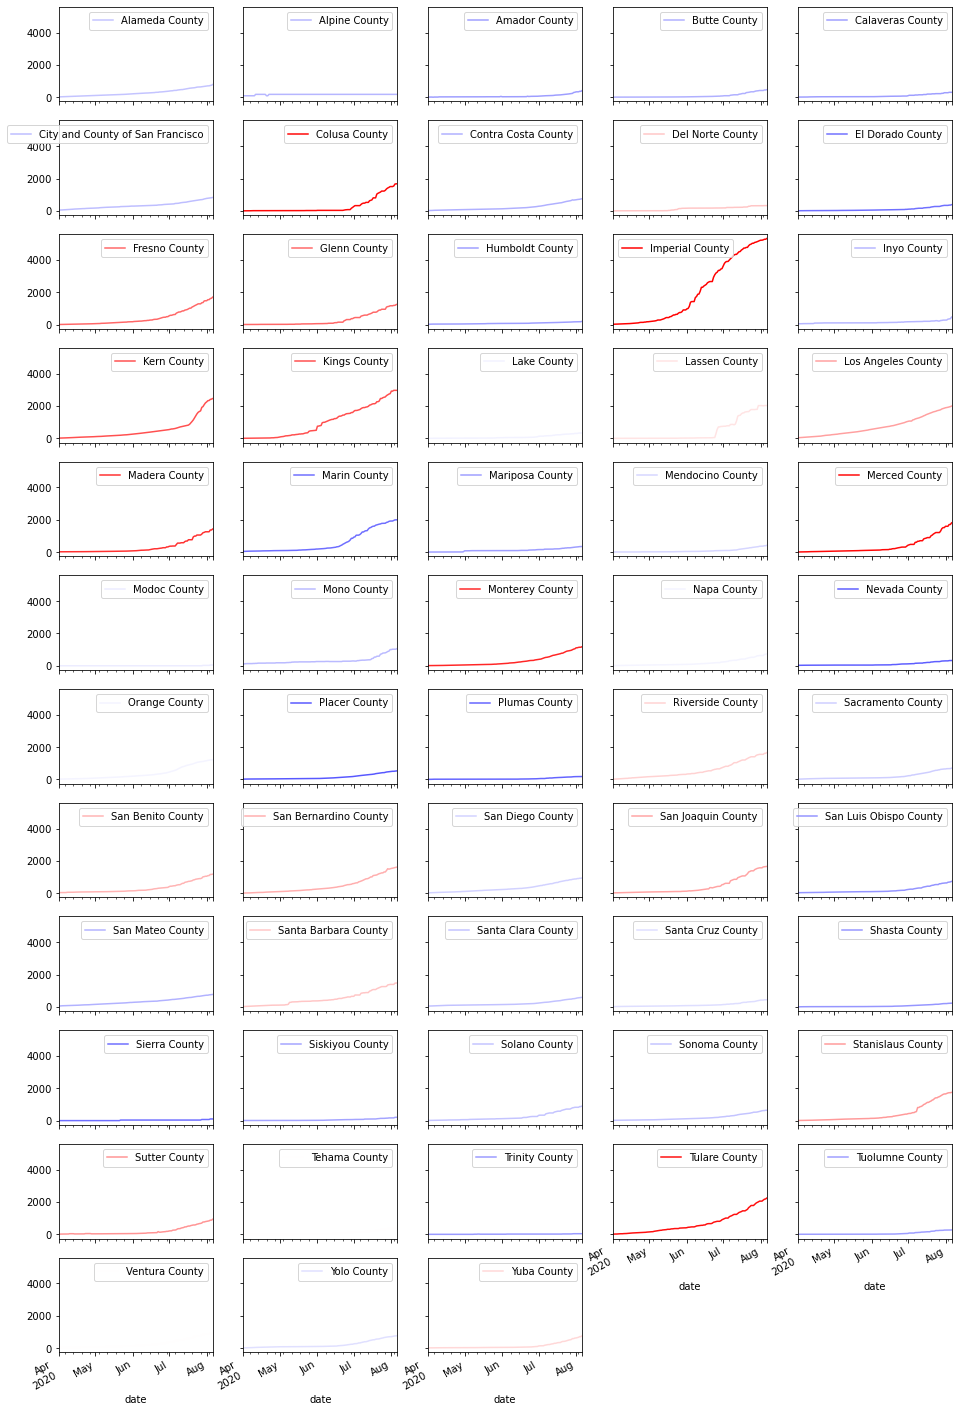

In [19]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 60), color=col_map);